In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from non_linearity.environment import Particle
from non_linearity.simulation import simulation
import non_linearity.utils.constants as ct
from scipy import signal as sn

In [58]:
#mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [106]:
freq = 79e3
omega = 2*np.pi*freq
T = 1 / freq
max_time = 500 * T
M = 500
delta_t = 1e-7
N_time = int(max_time / delta_t)
t = np.linspace(0, max_time, int(N_time))
gamma = 13e3
gain1 = 5.94e5
gain2 = -5.94e5

In [107]:
env = Particle(omega, gamma, radius=70e-9)

In [108]:
print(max_time, (T/4)/delta_t, max_time/delta_t)
print('9.1GB RAM spent')
print('use smallest delta_t such that delay amount is appropriate')
print('commit between max_time and trace amount')

0.006329113924050634 31.645569620253166 63291.13924050634
9.1GB RAM spent
use smallest delta_t such that delay amount is appropriate
commit between max_time and trace amount


In [109]:
def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]/2))
        if not np.isnan(pxx.max()) and not pxx.max() > 1e12:
            pxxs.append(pxx)
    return freq, np.array(pxxs)


def generate_traces(env, gain, delta_t, N_time,  M, delay_range):
    cubic_delayed = {i: [None] for i in delay_range}
    print("-- Creating traces --")
    for key in tqdm(cubic_delayed.keys()):
        cubic = np.zeros(shape=(M, N_time))
        for i in range(M):
            data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, gain*(env.zp_x**3/env.zp_p), key)
            data = np.array(data)
            cubic[i, :] = data
        cubic_delayed[key] = cubic
    print("-- Analysing and making PSD --")
    delay_areas,  areas_std = [], []
    for key in tqdm(list(cubic_delayed.keys())):
        freq, pxx = psd(cubic_delayed[key], delta_t)
        delay_areas.append(pxx.sum(axis=1).mean())
        areas_std.append(pxx.sum(axis=1).std())

    return delay_areas, areas_std, freq

In [115]:
delay_range = [0, int(0.25*T/delta_t), int(0.5*T/delta_t), int(0.75*T/delta_t), int(T/delta_t)]
areas_gain1, std_1, freq = generate_traces(env, gain1, delta_t, N_time, M, delay_range)

-- Creating traces --


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


-- Analysing and making PSD --


 60%|██████    | 3/5 [00:10<00:07,  3.53s/it]/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1878: RuntimeWarning: overflow encountered in multiply
  result = np.conjugate(result) * result
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1878: RuntimeWarning: invalid value encountered in multiply
  result = np.conjugate(result) * result
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1880: RuntimeWarning: invalid value encountered in multiply
  result *= scale
100%|██████████| 5/5 [00:17<00:00,  3.49s/it]


In [116]:
delay_range = [0, int(0.25*T/delta_t), int(0.5*T/delta_t), int(0.75*T/delta_t), int(T/delta_t)]
areas_gain2, std_2, freq = generate_traces(env, gain2, delta_t, N_time, M, delay_range)

-- Creating traces --


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


-- Analysing and making PSD --


100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


In [117]:
def autocor_0(t, omega, gamma, m= 3.368e-18, T = 293):
    C = 2*(gamma*ct.kb*T/m)
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    T0 = C*np.exp(-gamma*t/2)*(2*Omega*np.cos(Omega*t)+gamma*np.sin(Omega*t))/(4*gamma*Omega*(omega**2))
    return T0


def autocor_perturbation(t, omega, gamma, b, tau, m= 3.368e-18, T = 293):
    T0 = autocor_0(t, omega, gamma, m=m)
    C = 2*(gamma*ct.kb*T/m) 
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    mult = np.exp(-gamma*t/2)/(64*(gamma**3)*(Omega**4)*(omega**6))
    part1 = np.exp(gamma*tau/2)*(8*gamma*(Omega**4)-4*(omega**2)*(gamma**2)*(Omega**2)*(t-tau))*np.cos(Omega*(t-tau))
    
    part2 = Omega*np.exp(gamma*tau/2)*(8*gamma*(Omega**2)*(omega**2)*(t-tau)+\
                                       8*(Omega**4)+4*(gamma**2)*(omega**2)+6*(gamma**2)*(Omega**2))*np.sin(Omega*(t-tau))
    part3 = np.exp(-gamma*tau/2)*(Omega**2)*(2*Omega*(gamma**2)-8*(Omega**3))*np.sin(Omega*(t+tau))
    part4 = np.exp(-gamma*tau/2)*8*gamma*(Omega**4)*np.cos(Omega*(t+tau))
    T1 = -3*C*C*b*mult*(part1+part2+part3+part4)
    return T0+T1

def theoretical_area_frac(omega, gamma, gain, delay, m=3.368e-18, T=293):
    T1 = autocor_perturbation(0, omega, gamma, gain, delay, m=m, T=T)
    return T1

In [118]:
theory_delays = np.array(delay_range)*delta_t
areas_1 = theoretical_area_frac(env.__omega__, env.__gamma__, -gain1/env._m_, theory_delays, m=env._m_)
areas_2 = theoretical_area_frac(env.__omega__, env.__gamma__, -gain2/env._m_, theory_delays, m=env._m_)

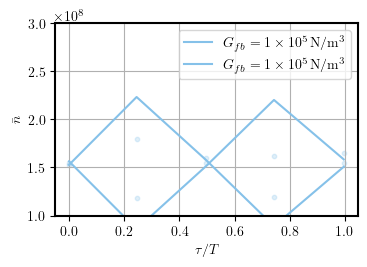

In [119]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
fig.set_size_inches(3*1.3, 2.5, forward=True)

plt.plot(theory_delays/T, areas_1/(env.zp_x**2)-1/2, color=colors[1], label=r"$G_{fb}=1\times 10^5\,\textrm{N/m}{}^3$")
plt.scatter(delta_t*np.array(delay_range)/T, np.array(areas_gain1)*np.diff(freq)[0]-1/2,s=10, color=colors[1], alpha=0.25, label=r"_$G_{fb}=1\times 10^5\,\textrm{N/m}{}^3$")

plt.plot(theory_delays/T, areas_2/(env.zp_x**2)-1/2, color=colors[1], label=r"$G_{fb}=1\times 10^5\,\textrm{N/m}{}^3$")
plt.scatter(delta_t*np.array(delay_range)/T, np.array(areas_gain2)*np.diff(freq)[0]-1/2,s=10, color=colors[1], alpha=0.25, label=r"_$G_{fb}=1\times 10^5\,\textrm{N/m}{}^3$")


plt.xlabel(r'$\tau/T$')
plt.ylabel(r'$\bar{n}$')
plt.ylim([1.0e8, 3e8])
plt.legend()
plt.grid()

In [120]:
(np.array(areas_gain1)*np.diff(freq)[0]-0.5)

array([1.54661126e+08, 1.18683754e+08, 1.54614859e+08, 1.62056042e+08,
       1.64984613e+08])

In [121]:
areas_1/env.zp_x**2

array([1.56397396e+08, 8.59223322e+07, 1.51693263e+08, 2.20136711e+08,
       1.58373018e+08])

In [136]:
def create_sub_df(areas_s, areas_t, std_sim, delay_range, delta_t, freq, gain, env):
    df = pd.DataFrame()
    df['delay'] = np.array(delay_range)*delta_t
    df['phonons_s'] = (np.array(areas_s)*np.diff(freq)[0]-0.5)
    df['std_s'] = std_sim
    df['phonons_t'] = areas_t/env.zp_x**2
    df['gain'] = gain
    return df


In [137]:
df1 = create_sub_df(areas_gain1, areas_1, std_1, delay_range, delta_t, freq, gain1, env)
df2 = create_sub_df(areas_gain2, areas_2, std_2, delay_range, delta_t, freq, gain2, env)

In [139]:
df = pd.concat([df1, df2])
df.to_csv("../data/phonons_theory_simulation.csv", index=None)

In [140]:
df.head(20)

,delay,phonons_s,std_s,phonons_t,gain
0,0.000000,1.546611e+08,91982.465900,1.563974e+08,594000.0
1,0.000003,1.186838e+08,48820.479181,8.592233e+07,594000.0
2,0.000006,1.546149e+08,90284.008318,1.516933e+08,594000.0
3,0.000009,1.620560e+08,40194.910972,2.201367e+08,594000.0
4,0.000013,1.649846e+08,110469.529254,1.583730e+08,594000.0
0,0.000000,1.528439e+08,86132.432908,1.527233e+08,-594000.0
1,0.000003,1.790805e+08,0.000000,2.231984e+08,-594000.0
2,0.000006,1.595776e+08,94719.042047,1.574275e+08,-594000.0
3,0.000009,1.195704e+08,49881.221932,8.898401e+07,-594000.0
4,0.000013,1.544246e+08,91129.787340,1.507477e+08,-594000.0
